In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import pickle
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import shap

/root/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
df = pd.read_csv("filtered_numeric_data.csv")
df.dropna(inplace=True)
df = df[~np.isinf(df['comment_len'])]

# Remove avg_engagement_last_20 column
# df = df.drop(['avg_engagement_last_20'], axis=1)

# Check for excessively large values
# print((np.abs(df) > 1e10).sum(), "values greater than 1e10 in X")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51162 entries, 0 to 51212
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   video_id                 51162 non-null  object 
 1   duration                 51162 non-null  float64
 2   comment                  51162 non-null  float64
 3   sponsored                51162 non-null  bool   
 4   likes_to_views           51162 non-null  float64
 5   title_len                51162 non-null  float64
 6   description_len          51162 non-null  float64
 7   avg_engagement_last_20   51162 non-null  float64
 8   fre_title                51162 non-null  float64
 9   fre_description          51162 non-null  float64
 10  hours_since_last_upload  51162 non-null  float64
 11  avg_like_count           51162 non-null  float64
 12  comment_len              51162 non-null  float64
 13  fre_comment              51162 non-null  float64
 14  vader_comment            51

In [3]:
# checking distribution of likes to views


In [11]:
# train/val/test split
train_ratio = 0.70
validation_ratio = 0.10
test_ratio = 0.20

# df = pd.read_csv("numeric.csv")
dataX = df.drop(["likes_to_views","video_id","avg_engagement_last_20"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(dataX, df["likes_to_views"] * 100, test_size=1 - train_ratio, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42) 

y_test1 = y_test.copy()
print(x_train, x_val, x_test, y_test)


       duration   comment  sponsored  title_len  description_len  fre_title  \
37555  3.731699 -0.192434      False   4.356709         0.414782  -0.174431   
32159  2.915064 -0.177973      False   4.110874         0.070456   0.749543   
4313   2.725672 -0.207382      False   3.637586        -0.691654   0.115598   
28070  3.400642 -0.175211      False   4.276666         0.850929   0.272582   
47217  3.759260 -0.204133      False   4.369448        -0.322842   0.900512   
...         ...       ...        ...        ...              ...        ...   
11308  2.446685 -0.185610      False   4.025352         1.655888   0.514316   
44778  1.356694 -0.228343      False   3.784190        -0.414662  -0.708029   
38198  2.663750  0.478942       True   4.330733         0.399479  -0.009689   
862    2.760010  0.108808      False   3.688879        -0.273871   0.246245   
15820  1.788978 -0.218919      False   4.158883        -0.748276   0.300610   

       fre_description  hours_since_last_upload  av

In [8]:
# Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=0), param_grid, cv=5)
grid_search.fit(x_train, y_train)

print(grid_search.best_params_)

regression = RandomForestRegressor(n_estimators=grid_search.best_params_['n_estimators'],
                                   max_depth=grid_search.best_params_['max_depth'],
                                   min_samples_split=grid_search.best_params_['min_samples_split'],
                                   random_state=0)
regressor = regression.fit(x_train, y_train)

# 100 - Mean absolute percentage error
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

y_pred = regressor.predict(x_test)  # Get predictions
mape_score = mape(y_test, y_pred)
accuracy = 100 - mape_score  # Convert error into accuracy

print(f"MAPE: {mape_score:.2f}%")
print(f"Regression Accuracy: {accuracy:.2f}%")

{'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 200}
MAPE: 48.06%
Regression Accuracy: 51.94%


In [56]:
rfr = RandomForestRegressor()
rfr.fit(x_train, y_train)
with open('default_random_forest_model.pkl', 'wb') as f:
    pickle.dump(rfr, f)

In [61]:
rfr = pickle.load(open('default_random_forest_model.pkl', 'rb'))

In [71]:
rfr = RandomForestRegressor(n_estimators=200, max_depth=30, min_samples_split=10, random_state=0)
rfr.fit(x_train, y_train)
with open('grid_random_forest_model.pkl', 'wb') as f:
    pickle.dump(rfr, f)

In [14]:
rfr = pickle.load(open('grid_random_forest_model.pkl', 'rb'))

In [17]:
explainer = shap.Explainer(rfr)

# Compute SHAP values
shap_values = explainer(x_test)
shap.summary_plot(shap_values, x_test)

KeyboardInterrupt: 

In [44]:
# getting hyper parameters
rfr.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 30,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

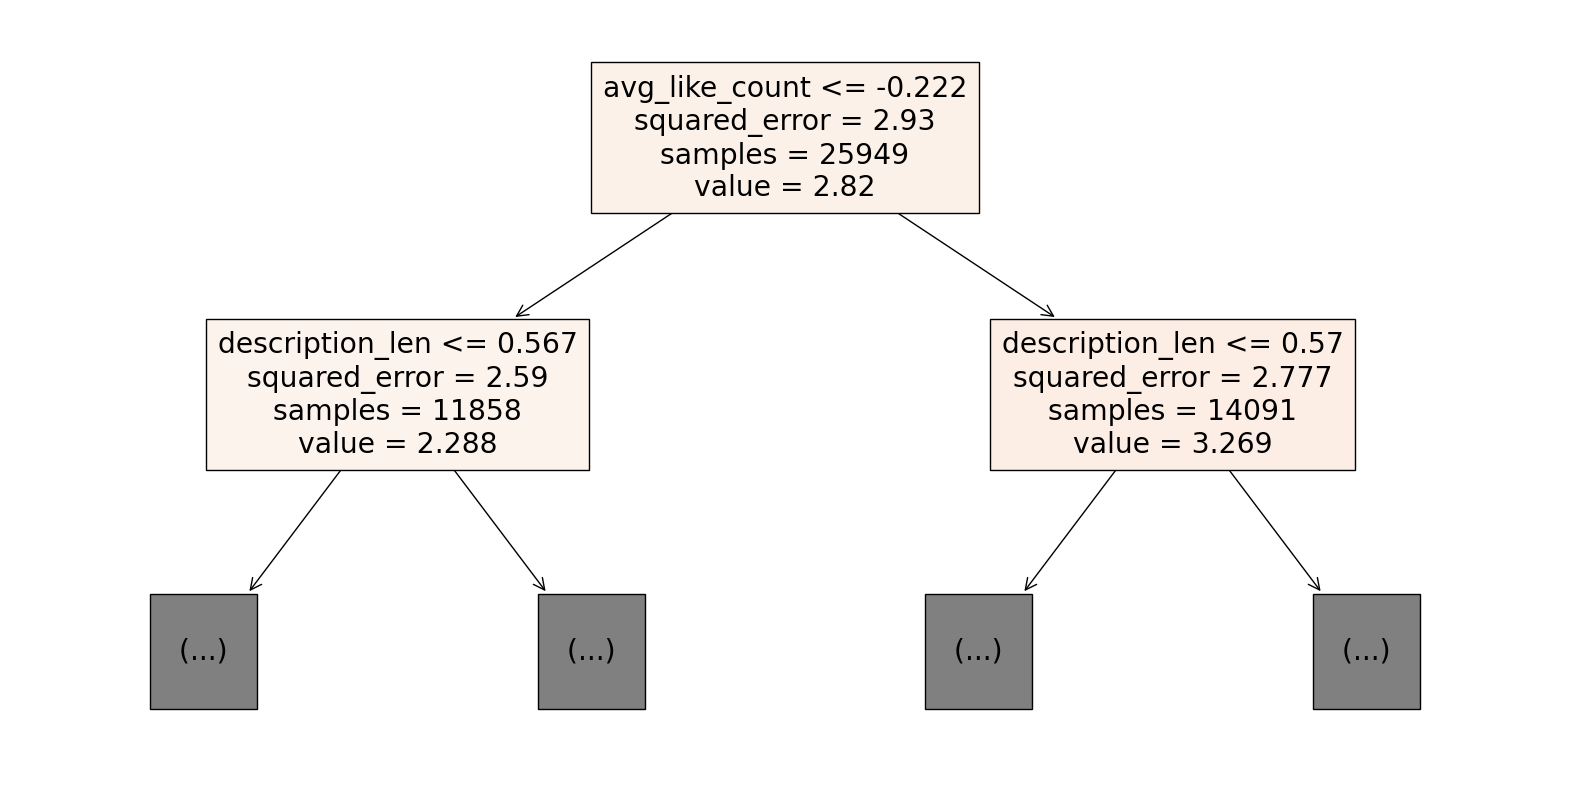

In [28]:
# a tree
plt.figure(figsize=(20,10))
plot_tree(rfr.estimators_[1], feature_names=dataX.columns, filled=True, max_depth=1)
plt.show()

In [12]:
importances = rfr.feature_importances_
print("Feature Importances: ", importances)
print(dataX.columns)
feature_names = dataX.columns if hasattr(dataX, 'columns') else [f"Feature_{i}" for i in range(dataX.shape[1])]

feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print(feature_importances)

Feature Importances:  [0.09315027 0.12183637 0.00576003 0.07238937 0.15208974 0.05383522
 0.10625984 0.09544525 0.17387196 0.04117847 0.03993719 0.04424628]
Index(['duration', 'comment', 'sponsored', 'title_len', 'description_len',
       'fre_title', 'fre_description', 'hours_since_last_upload',
       'avg_like_count', 'comment_len', 'fre_comment', 'vader_comment'],
      dtype='object')
avg_like_count             0.173872
description_len            0.152090
comment                    0.121836
fre_description            0.106260
hours_since_last_upload    0.095445
duration                   0.093150
title_len                  0.072389
fre_title                  0.053835
vader_comment              0.044246
comment_len                0.041178
fre_comment                0.039937
sponsored                  0.005760
dtype: float64


In [67]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = rfr.predict(x_test)
# MSE
mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
# MAE
mae = mean_absolute_error(y_test, y_pred)
print("MAE: ", mae)
# R²
r2 = r2_score(y_test, y_pred)
print("R²: ", r2)
# MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print("MAPE: ", mape)
# STD of residuals
residuals = y_test - y_pred
std = np.std(residuals)
print("STD: ", std)
# Optional: Flag predictions with error > 2*STD
threshold = 2 * std
outliers = np.abs(residuals) > threshold
print("Percent: ", (len(residuals) -np.sum(outliers)) / len(residuals) * 100, "%")



MSE:  1.061981788118368
MAE:  0.6622292320863548
R²:  0.6355656787870267
MAPE:  28.478649207797684
STD:  1.0301713539164503
Percent:  95.48563611491107 %


In [48]:
# with engagement_avg:
MSE:  1.061981788118368
MAE:  0.6622292320863548
R²:  0.6355656787870267
MAPE:  28.478649207797684
STD:  1.0301713539164503
Percent:  92.78874340433848 %
# without engagement_avg:
MSE:  0.9397461477210337
MAE:  0.6277829907024842
R²:  0.677512596459847
MAPE:  27.604541707742165
STD:  0.9690545075401112
Percent:  94.35215946843853 %

In [5]:
# CNN


In [3]:
def model_accuracy(y_test, pred, threshold):
    abs_errors = np.abs(y_test - pred)
    return np.mean(abs_errors < threshold)

In [20]:
# XGBoost Default Parameters
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

xgb_def = XGBRegressor()
xgb_def.fit(x_train,y_train, eval_set=[(x_val, y_val)])
xgb_def_pred = xgb_def.predict(x_test)

# save default model
xgb_def.save_model("xgb_def_model.json")

# Evaluate the model
mse = mean_squared_error(y_test, xgb_def_pred)
r2 = r2_score(y_test, xgb_def_pred)
mape = mean_absolute_percentage_error(y_test, xgb_def_pred)
mae = mean_absolute_error(y_test, xgb_def_pred)
xgb_def_accuracy = model_accuracy(y_test, xgb_def_pred, 1.73)

print("Test Accuracy:", xgb_def_accuracy)
print("Test MSE:", mse)
print("Test R2 Score:", r2)
print("Test MAPE Score", mape)
print("Test MAE Score", mae)
print("Train Score (R2):", xgb_def.score(x_train, y_train))


[0]	validation_0-rmse:1.50983
[1]	validation_0-rmse:1.34212
[2]	validation_0-rmse:1.24509
[3]	validation_0-rmse:1.19020
[4]	validation_0-rmse:1.15935
[5]	validation_0-rmse:1.13963
[6]	validation_0-rmse:1.12745
[7]	validation_0-rmse:1.12055
[8]	validation_0-rmse:1.11522
[9]	validation_0-rmse:1.11292
[10]	validation_0-rmse:1.11061
[11]	validation_0-rmse:1.10936
[12]	validation_0-rmse:1.10973
[13]	validation_0-rmse:1.10639
[14]	validation_0-rmse:1.10508
[15]	validation_0-rmse:1.10422
[16]	validation_0-rmse:1.10156
[17]	validation_0-rmse:1.10040
[18]	validation_0-rmse:1.10014
[19]	validation_0-rmse:1.09942
[20]	validation_0-rmse:1.09898
[21]	validation_0-rmse:1.09806
[22]	validation_0-rmse:1.09871
[23]	validation_0-rmse:1.09942
[24]	validation_0-rmse:1.09881
[25]	validation_0-rmse:1.09805
[26]	validation_0-rmse:1.09632
[27]	validation_0-rmse:1.09586
[28]	validation_0-rmse:1.09629
[29]	validation_0-rmse:1.09550
[30]	validation_0-rmse:1.09484
[31]	validation_0-rmse:1.09399
[32]	validation_0-

In [19]:
# XGBoost Best Hyperparameters
# !pip install xgboost
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV



# find ideal hyperparameters
params = {
    'max_depth': [2, 4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200, 300, 500, 700],
    'alpha': [0, 1, 10, 100, 1000]
        }
# xgb = XGBRegressor(objective='reg:squarederror')

# Perform grid search
# grid_search = GridSearchCV(estimator=xgb, param_grid=params, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
# grid_search.fit(x_train, y_train)       
            
# print("Best Parameters:", grid_search.best_params_)
# print("Best Score:", grid_search.best_score_)

# train using best params
# gbm_best = XGBRegressor(**grid_search.best_params_)
gbm_best = XGBRegressor(alpha=10, learning_rate=0.05, max_depth=6, n_estimators=500)
gbm_best.fit(x_train,y_train, eval_set=[(x_val, y_val)])

xgb_best_pred = gbm_best.predict(x_test)
# print("predictions", predictions)

# save best model
# gbm_best.save_model("xgb_best_model_no_avg_engagement.json")

# Evaluate the model
mse = mean_squared_error(y_test, xgb_best_pred)
r2 = r2_score(y_test, xgb_best_pred)
mape = mean_absolute_percentage_error(y_test, xgb_best_pred)
mae = mean_absolute_error(y_test, xgb_best_pred)
xgb_best_accuracy = model_accuracy(y_test, xgb_best_pred, 1.73)

print("Test Accuracy:", xgb_best_accuracy)
print("Test MSE:", mse)
print("Test R2 Score:", r2)
print("Test MAPE Score", mape)
print("Test MAE Score", mae)
print("Train Score (R2):", gbm_best.score(x_train, y_train))


# print("test score", gbm.score(x_test,y_test))
# print("train score", gbm.score(x_train,y_train))

[0]	validation_0-rmse:1.77962
[1]	validation_0-rmse:1.76106
[2]	validation_0-rmse:1.74301
[3]	validation_0-rmse:1.72677
[4]	validation_0-rmse:1.71193
[5]	validation_0-rmse:1.69747
[6]	validation_0-rmse:1.68410
[7]	validation_0-rmse:1.67104
[8]	validation_0-rmse:1.66009
[9]	validation_0-rmse:1.64778
[10]	validation_0-rmse:1.63835
[11]	validation_0-rmse:1.62852
[12]	validation_0-rmse:1.61917
[13]	validation_0-rmse:1.60989
[14]	validation_0-rmse:1.60252
[15]	validation_0-rmse:1.59497
[16]	validation_0-rmse:1.58751
[17]	validation_0-rmse:1.58062
[18]	validation_0-rmse:1.57396
[19]	validation_0-rmse:1.56724
[20]	validation_0-rmse:1.56097
[21]	validation_0-rmse:1.55518
[22]	validation_0-rmse:1.55098
[23]	validation_0-rmse:1.54654
[24]	validation_0-rmse:1.54129
[25]	validation_0-rmse:1.53686
[26]	validation_0-rmse:1.53215
[27]	validation_0-rmse:1.52775
[28]	validation_0-rmse:1.52355
[29]	validation_0-rmse:1.52013
[30]	validation_0-rmse:1.51612
[31]	validation_0-rmse:1.51258
[32]	validation_0-

Dropping non-numeric columns: ['video_id']
Mean Absolute Error: 0.7115259232420335
Mean Squared Error: 1.2037855526275185
R^2 Score: 0.6050481458251487
MAPE: 0.32010018375541544
0.9222078886673704


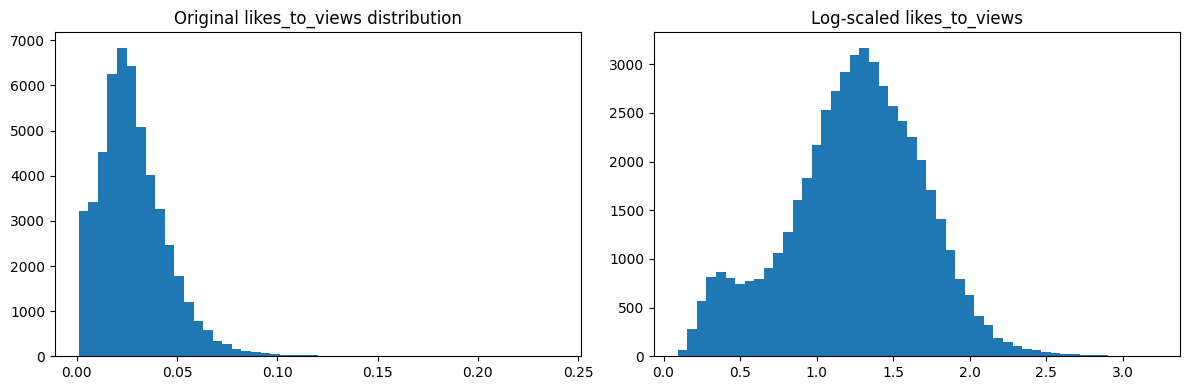

Coefficients: [-2.37027898e-03  1.15447978e-03  1.68296179e-03 -1.62341557e-03
 -2.97559794e-04  9.87903469e-01  1.39111718e-04 -1.78185395e-04
 -4.62102173e-05 -4.33703636e-04  1.46583685e-05  2.44572475e-05
  7.32933779e-05]
Intercept: 0.01232156709746058
Features: ['duration', 'comment', 'sponsored', 'title_len', 'description_len', 'avg_engagement_last_20', 'fre_title', 'fre_description', 'hours_since_last_upload', 'avg_like_count', 'comment_len', 'fre_comment', 'vader_comment']
                            OLS Regression Results                            
Dep. Variable:         likes_to_views   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     6387.
Date:                Mon, 14 Apr 2025   Prob (F-statistic):               0.00
Time:                        18:24:35   Log-Likelihood:             1.6155e+05
No. Observations:               51162  

In [11]:
# log scale linear regression
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

df_clean = df.copy()
df_clean = df_clean.dropna()  # Drop rows with NaN target


#removing specific columns in addition to likes_to_views
X2 = df_clean.drop(columns=["likes_to_views", "avg_engagement_last_20"])
non_numeric_cols = X2.select_dtypes(include=['object']).columns
print("Dropping non-numeric columns:", list(non_numeric_cols))
X2 = X2.drop(columns=non_numeric_cols)

X2_with_quadratics = X2.copy()

y2 = df_clean["likes_to_views"] 
y2_log = np.log1p(y2)  

# Split ratios
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

X2_train, X2_test, y2_log_train, y2_log_test = train_test_split(
    X2_with_quadratics, y2_log, test_size=test_ratio / (test_ratio + validation_ratio), random_state=42)

# Fit the model
reg2 = LinearRegression()
reg2.fit(X2_train, y2_log_train)

y2_log_pred = reg2.predict(X2_test)
y2_pred = np.expm1(y2_log_pred) * 100
y2_test = np.expm1(y2_log_test) * 100

# Calculate metrics
mae = mean_absolute_error(y2_test, y2_pred)
mse = mean_squared_error(y2_test, y2_pred)
mape = mean_absolute_percentage_error(y2_test, y2_pred)
r2 = r2_score(y2_test, y2_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"MAPE: {mape}")
print(model_accuracy(y2_test, y2_pred, 1.73))

# Visualizations
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df["likes_to_views"].dropna(), bins=50)
plt.title("Original likes_to_views distribution")

plt.subplot(1, 2, 2)
plt.hist(np.log1p(df["likes_to_views"].dropna() * 100), bins=50)
plt.title("Log-scaled likes_to_views")

plt.tight_layout()
plt.show()

# Model interpretation
print("Coefficients:", reg2.coef_)
print("Intercept:", reg2.intercept_)

# Statistical summary using statsmodels
import statsmodels.api as sm

X2_array = np.asarray(X2_with_quadratics, dtype=float)
X2_with_const = sm.add_constant(X2_array)
print("Features:", X2_with_quadratics.columns.tolist())

ols_model = sm.OLS(y2_log, X2_with_const).fit()
print(ols_model.summary())
pvals = ols_model.pvalues.sort_values()

pval_df = pd.DataFrame({
    'Variable': pvals.index,
    'P-Value': pvals.values
})
pd.options.display.float_format = '{:.2e}'.format


# Show sorted p-values
print(pval_df)

print("Features:", X2_with_quadratics.columns.tolist())
pval_df = pd.DataFrame({
    'Variable': ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12'],
    'P-Value': X2_with_quadratics.columns.tolist()
})

# Set display precision
# Show sorted p-values
print(pval_df)

Dropping non-numeric columns: ['video_id']
Mean Absolute Error: 0.7115259232420335
Mean Squared Error: 1.2037855526275185
R^2 Score: 0.6050481458251487
MAPE: 0.32010018375541544
0.9222078886673704


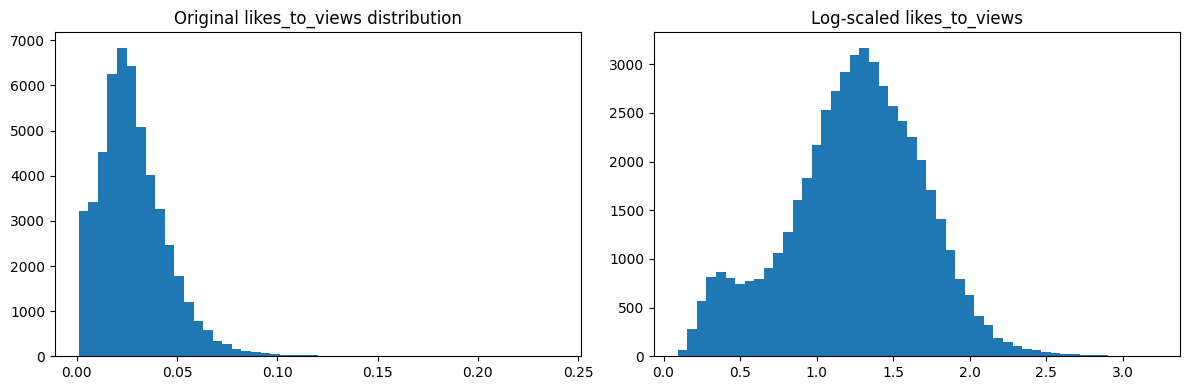

Coefficients: [-2.37027898e-03  1.15447978e-03  1.68296179e-03 -1.62341557e-03
 -2.97559794e-04  9.87903469e-01  1.39111718e-04 -1.78185395e-04
 -4.62102173e-05 -4.33703636e-04  1.46583685e-05  2.44572475e-05
  7.32933779e-05]
Intercept: 0.01232156709746058
Features: ['duration', 'comment', 'sponsored', 'title_len', 'description_len', 'avg_engagement_last_20', 'fre_title', 'fre_description', 'hours_since_last_upload', 'avg_like_count', 'comment_len', 'fre_comment', 'vader_comment']
                            OLS Regression Results                            
Dep. Variable:         likes_to_views   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     6387.
Date:                Mon, 14 Apr 2025   Prob (F-statistic):               0.00
Time:                        18:47:11   Log-Likelihood:             1.6155e+05
No. Observations:               51162  

In [4]:
# log scale linear regression
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

df_clean = df.copy()
df_clean = df_clean.dropna()  # Drop rows with NaN target


#removing specific columns in addition to likes_to_views
X2 = df_clean.drop(columns=["likes_to_views"])
non_numeric_cols = X2.select_dtypes(include=['object']).columns
print("Dropping non-numeric columns:", list(non_numeric_cols))
X2 = X2.drop(columns=non_numeric_cols)

X2_with_quadratics = X2.copy()

y2 = df_clean["likes_to_views"] 
y2_log = np.log1p(y2)  

# Split ratios
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

X2_train, X2_test, y2_log_train, y2_log_test = train_test_split(
    X2_with_quadratics, y2_log, test_size=test_ratio / (test_ratio + validation_ratio), random_state=42)

# Fit the model
reg2 = LinearRegression()
reg2.fit(X2_train, y2_log_train)

y2_log_pred = reg2.predict(X2_test)
y2_pred = np.expm1(y2_log_pred) * 100
y2_test = np.expm1(y2_log_test) * 100

# Calculate metrics
mae = mean_absolute_error(y2_test, y2_pred)
mse = mean_squared_error(y2_test, y2_pred)
mape = mean_absolute_percentage_error(y2_test, y2_pred)
r2 = r2_score(y2_test, y2_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"MAPE: {mape}")
print(model_accuracy(y2_test, y2_pred, 1.73))

# Visualizations
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df["likes_to_views"].dropna(), bins=50)
plt.title("Original likes_to_views distribution")

plt.subplot(1, 2, 2)
plt.hist(np.log1p(df["likes_to_views"].dropna() * 100), bins=50)
plt.title("Log-scaled likes_to_views")

plt.tight_layout()
plt.show()

# Model interpretation
print("Coefficients:", reg2.coef_)
print("Intercept:", reg2.intercept_)

# Statistical summary using statsmodels
import statsmodels.api as sm

X2_array = np.asarray(X2_with_quadratics, dtype=float)
X2_with_const = sm.add_constant(X2_array)
print("Features:", X2_with_quadratics.columns.tolist())

ols_model = sm.OLS(y2_log, X2_with_const).fit()
print(ols_model.summary())
pvals = ols_model.pvalues.sort_values()

pval_df = pd.DataFrame({
    'Variable': pvals.index,
    'P-Value': pvals.values
})
pd.options.display.float_format = '{:.2e}'.format


# Show sorted p-values
print(pval_df)

print("Features:", X2_with_quadratics.columns.tolist())
pval_df = pd.DataFrame({
    'Variable': ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13'],
    'P-Value': X2_with_quadratics.columns.tolist()
})

# Set display precision
# Show sorted p-values
print(pval_df)

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Prepare data
X2 = df.drop(columns=["likes_to_views", ])  # Drop target column
non_numeric_cols = X2.select_dtypes(include=['object']).columns
print("Dropping non-numeric columns:", list(non_numeric_cols))
X2 = X2.drop(columns=non_numeric_cols)

y2 = df["likes_to_views"] 

# Train/Validation/Test Split
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42
)

# Define Lasso model and parameter grid
lasso = Lasso(max_iter=10000)
param_grid = {'alpha': np.arange(0.01, 1.005, 0.005)}

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X2_train, y2_train)

# Best model
best_lasso = grid_search.best_estimator_
y2_pred = best_lasso.predict(X2_test)

# Metrics
mae = mean_absolute_error(y2_test, y2_pred)
mse = mean_squared_error(y2_test, y2_pred)
r2 = r2_score(y2_test, y2_pred)

print(f"Best Alpha: {grid_search.best_params_['alpha']}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")


Dropping non-numeric columns: ['video_id']
Best Alpha: 0.01
Mean Absolute Error: 0.0130
Mean Squared Error: 0.0003
R^2 Score: -0.0001


In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

X2 = df.drop(columns=["likes_to_views", "avg_engagement_last_20"])  
non_numeric_cols = X2.select_dtypes(include=['object']).columns
print("Dropping non-numeric columns:", list(non_numeric_cols))
X2 = X2.drop(columns=non_numeric_cols)

y2 = df["likes_to_views"] * 100

train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42
)

scaler = StandardScaler()
X2_train_scaled = scaler.fit_transform(X2_train)
X2_test_scaled = scaler.transform(X2_test)

#alpha = 0.01
lasso = Lasso(alpha=0.01, max_iter=10000)
lasso.fit(X2_train_scaled, y2_train)

y2_pred = lasso.predict(X2_test_scaled)

mae = mean_absolute_error(y2_test, y2_pred)
mse = mean_squared_error(y2_test, y2_pred)
mape = mean_absolute_percentage_error(y2_test, y2_pred)
r2 = r2_score(y2_test, y2_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"MAPE: {mape}")
print(model_accuracy(y2_test, y2_pred, 1.73))


Dropping non-numeric columns: ['video_id']
Mean Absolute Error: 1.2232840525222681
Mean Squared Error: 2.7079865282399607
R^2 Score: 0.11153253328682478
MAPE: 0.8176171320960911
0.7676791368593878


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters: {'C': 0.1}
Best Cross-Validation Accuracy: 1.0
Test Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5100
           1       1.00      1.00      1.00      5133

    accuracy                           1.00     10233
   macro avg       1.00      1.00      1.00     10233
weighted avg       1.00      1.00      1.00     10233



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=395a814d-9932-4e75-96c1-b9471a984f5a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>